# Regression with a feed forward neural network
## Predict surface atmosphere-ocean temperature correlation

### Use K-Fold approach to split and re-split data, train/test on different quantiles of data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cf
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow import keras

from mlcdc import KFoldSurfaceFeeder

In [13]:
plt.style.use('./mlcdc.mplstyle')

In [2]:
ds = xr.open_zarr('../data/tcorr.predictors0.10lon.10lat.-1alev.-1olev.-1member.zarr')
ds['log10_atm_tprcp'] = np.log10(ds.atm_tprcp)
ds['atm_speed_srf'] = ds.atm_wind_speed.isel(alev=-1)
ds['ocn_speed_srf'] = ds.ocn_speed.isel(olev=0)
ds['ocn_u_srf'] = ds['ocn_u'].isel(olev=0)
ds['ocn_v_srf'] = ds['ocn_v'].isel(olev=0)
ds['log10_atm_tprcp'].attrs['long_name'] = 'derived log10 of tprcp'
ds['atm_speed_srf'].attrs['long_name'] = 'derived atmospheric surface wind speed'
ds['ocn_speed_srf'].attrs['long_name'] = 'derived ocean surface current speed'
ds['ocn_u_srf'].attrs['long_name'] = 'derived zonal ocean surface current speed'
ds['ocn_v_srf'].attrs['long_name'] = 'derived meridional ocean surface current speed'

ds['ocn_ubtav'] = ds['ocn_ubtav'].isel(olev=0)
ds['ocn_vbtav'] = ds['ocn_vbtav'].isel(olev=0)
ds['ocn_baro_srf'] = np.sqrt(ds.ocn_ubtav**2 + ds.ocn_vbtav**2)
ds['ocn_baro_srf'].attrs['long_name'] = 'derived barotropic ocean current speed'

ds['corr_atm_ocn'] = ds.corr_atm_ocn.isel(olev=0,alev=-1)

In [3]:
features_and_labels = [
    #'atm_cnvprcp_ave', # no idea what this is
    #'atm_ast',
    #'atm_T',
    'atm_q2m',
    'atm_qrain',
    'atm_t2m',
    #'atm_totprcp_ave',
    'atm_tprcp',
    #'log10_atm_tprcp',
    #'atm_u_srf',
    #'atm_v_srf',
    'atm_speed_srf',
    'ocn_MEKE',
    #'ocn_MEKE_Kh', # probably need MEKE, if anything, not the diffusivity ...
    'ocn_MLD',
    #'ocn_MLD_MLE_filtered', # just use instantaneous, not time filtered version...
    #'ocn_ave_ssh', # use instantaneous version
    'ocn_sfc',
    'ocn_sst',
    #'ocn_u_srf',
    #'ocn_v_srf',
    'ocn_speed_srf',
    'ocn_baro_srf',
    #'ocn_Temp',
    'corr_atm_ocn'
]

In [4]:
for key in features_and_labels:
    if 'long_name' in ds[key].attrs:
        print(f"{key:<24s}: {ds[key].long_name}")

atm_q2m                 : q2m
atm_qrain               : qrain
atm_t2m                 : t2m
atm_tprcp               : tprcp
atm_speed_srf           : derived atmospheric surface wind speed
ocn_MEKE                : Mesoscale Eddy Kinetic Energy
ocn_MLD                 : Instantaneous active mixing layer depth
ocn_sfc                 : Free surface Height
ocn_sst                 : Sea surface temperature (derived)
ocn_speed_srf           : derived ocean surface current speed
ocn_baro_srf            : derived barotropic ocean current speed


In [5]:
features = features_and_labels.copy()
features.remove('corr_atm_ocn')

## Prepare the data

In [7]:
kf = KFoldSurfaceFeeder(feature_names=features,
                 label_name='corr_atm_ocn',
                 mask_name='ocn_mask',
                 n_splits=5,
                 load_into_memory=True)

In [8]:
kf(ds)

## Create the model

Input layers are created in `KerasFeeder`, for simple linear regression, just merge the inputs and feed to output.

In [10]:
def make_model(xkf, regularizer=keras.regularizers.L2, regularization=1e-6,
               hidden_units=[16],
               hidden_activation=None,
               learning_rate=1e-4,
              ):
    
    if not isinstance(hidden_activation, (list, tuple, np.ndarray)):
        hidden_activation = [hidden_activation] * len(hidden_units)
    
    hidden = keras.layers.concatenate(xkf.inputs)
    
    for units, activation in zip(hidden_units, hidden_activation):
        hidden = keras.layers.Dense(
            units=units,
            activation=activation,
            kernel_regularizer=regularizer(regularization),
            bias_regularizer=regularizer(regularization),
        )(hidden)
    
    output = keras.layers.Dense(
        activation='tanh',
        units=1, name='ao_corr'
    )(hidden)
    
    # stick it together
    model = keras.Model(
        inputs=xkf.inputs,
        outputs=[output]
    )
    
    # compile
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=learning_rate,
        ),
        #loss=keras.losses.Huber(delta=1),
        #loss=keras.losses.MeanSquaredError(),
        loss=keras.losses.MeanAbsoluteError(),
    )
    return model

In [11]:
#units = [128]*3
units = [64]*6
activation = 'swish' #['tanh', 'tanh']

model_kw = {
    "regularizer": keras.regularizers.L1,
    "regularization" : 1e-7,
    "hidden_units" : units,
    "hidden_activation" : activation,
    "learning_rate" : 1e-3,
}

In [25]:
%%time
history = []
predictions = []

for i, (X, Xtest, y) in enumerate(zip(kf.x_training, kf.x_testing, kf.labels)):
    model = make_model(kf, **model_kw)
    h = model.fit(
        x=X,
        y=y['training'].values,
        epochs=200,
        batch_size=128,
        validation_split=0.2,
        verbose=False,
    )
    history.append(h)
    
    # Test it out
    prediction = model.predict(Xtest)
    xpred = xr.DataArray(prediction.squeeze(),
                         coords=y['testing'].coords,
                         dims=y['testing'].dims)
    predictions.append(xpred)

619/619 [==============================] - 1s 969us/step
CPU times: user 25min 33s, sys: 2min 15s, total: 27min 48s
Wall time: 17min 3s


## Plot performance for each split

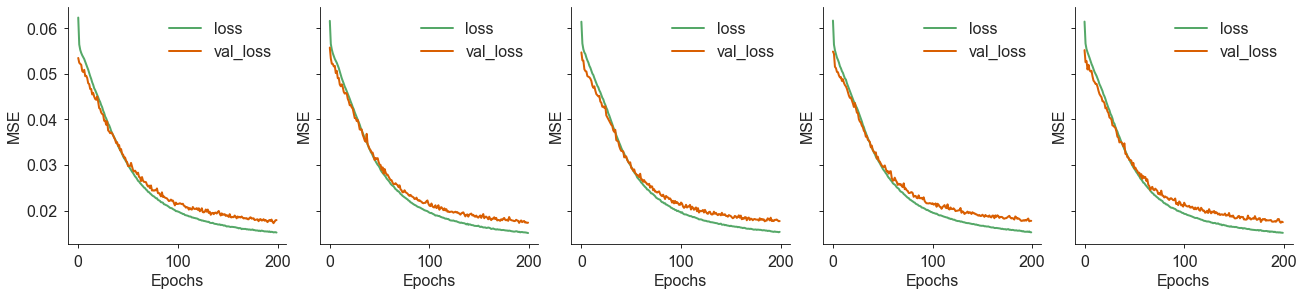

In [26]:
fig,axs=plt.subplots(1, kf.n_splits, figsize=(18,4),
                     sharex=True,
                     sharey=True,
                     constrained_layout=True,
                    )

for h, ax in zip(history, axs):
    for key in ['loss','val_loss']:
        ax.plot(h.history[key],label=key)
        
    ax.set(xlabel='Epochs', ylabel='MSE')
    ax.legend()

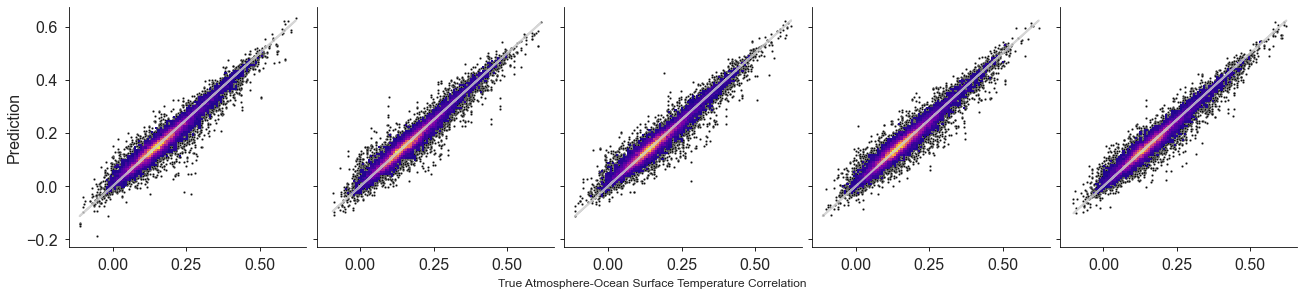

In [27]:
fig, axs = plt.subplots(1, kf.n_splits, figsize=(18,4),
                        sharex=True,
                        sharey=True,
                        constrained_layout=True,
                       )

for truth, xpred, ax in zip(kf.labels, predictions, axs):
    histoscatter(x=truth["testing"].values,
                 y=xpred.values,
                 ax=ax,
                )
    ax.set(xlabel="", ylabel="Prediction")
    fig.supxlabel("True Atmosphere-Ocean Surface Temperature Correlation")

## Gather all splits into single prediction/truth dataset

Do this in order to map back to physical space.

In [28]:
allpred = xr.concat(predictions, dim='sample')
this_pred = kf.unstack_horizontal(allpred.unstack().isel(member=3))

In [29]:
alltrue = xr.concat([l['testing'] for l in kf.labels], dim='sample')
this_truth = kf.unstack_horizontal(alltrue.unstack().isel(member=3))

In [30]:
cmap=plt.get_cmap('RdBu_r', lut=12)

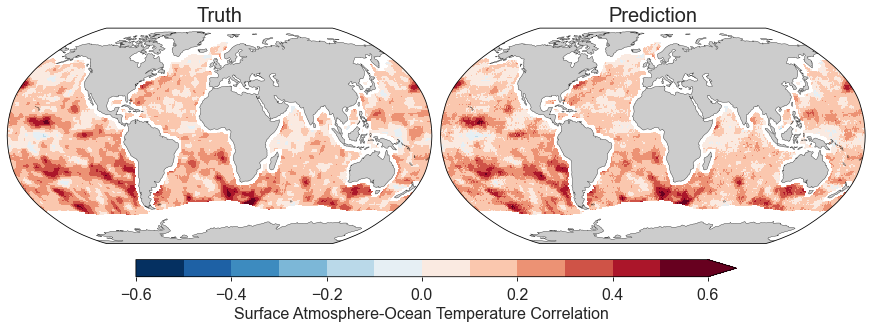

In [34]:
fig, axs = plt.subplots(1,2,figsize=(12,5),
                        constrained_layout=True,
                        subplot_kw={'projection':ccrs.Robinson()}
                       )
for xda, label, ax in zip([this_truth, this_pred],
                          ["Truth", "Prediction"],
                          axs):
    
    p = xda.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        vmax=.6,
        vmin=-.6,
        cmap=cmap,
        add_colorbar=False,
    )
    
    ax.add_feature(cf.LAND, color='.8')
    ax.add_feature(cf.COASTLINE)
    ax.set(title=label)

fig.colorbar(
    p,
    extend='max',
    ax=axs,
    aspect=35,
    shrink=.7,
    orientation='horizontal',
    label='Surface Atmosphere-Ocean Temperature Correlation',
    ticks=np.linspace(-.6,.6,7),
)
fig.savefig('../figures/surface_temperature_correlation_map_kfold.jpg', bbox_inches='tight')

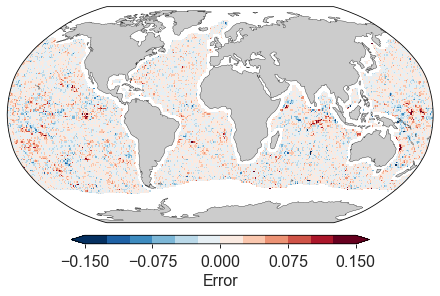

In [36]:
fig, ax = plt.subplots(constrained_layout=True,
                       subplot_kw={'projection':ccrs.Robinson()}
                       )
for xda, ax in zip([this_truth-this_pred], [ax]):
    
    p = xda.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        vmax=.15,
        vmin=-.15,
        cmap=cmap,
        add_colorbar=False,
    )
    
    ax.add_feature(cf.LAND, color='.8')
    ax.add_feature(cf.COASTLINE)

fig.colorbar(
    p,
    extend='both',
    ax=ax,
    aspect=35,
    shrink=.7,
    orientation='horizontal',
    label='Error',
    ticks=np.linspace(-.15,.15,5),
)
fig.savefig('../figures/surface_temperature_correlation_map_kfold_error.jpg', bbox_inches='tight')

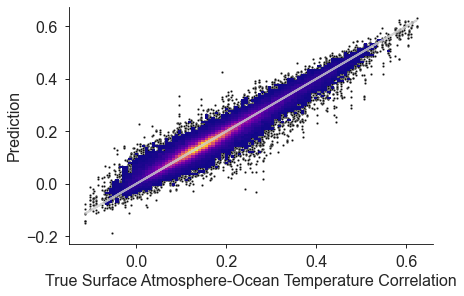

In [42]:
fig, ax = plt.subplots(constrained_layout=True)
histoscatter(x=alltrue, y=allpred, ax=ax, hist_kw={'pthresh':.01})
ax.set(xlabel="True Surface Atmosphere-Ocean Temperature Correlation",
       ylabel="Prediction",
      )
fig.savefig('../figures/surface_correlation_prediction_histogram_kfold.jpg', bbox_inches='tight', dpi=300)
fig.savefig('../figures/surface_correlation_prediction_histogram_kfold.pdf', bbox_inches='tight')